### About the Project

In this project we will be using the LSTM model to predict stock prices. We make use of data gotten about Amazon from yfinance from 01-01-1997 till 21-09-2024 and then we will us it to make predictions for the next 10 years.

In [39]:
! pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 9.8 MB/s eta 0:00:00


In [40]:
#import all necessary dependencies
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchmetrics

In [3]:
# Define the ticker symbol for Amazon
ticker_symbol = 'AMZN'

# Define the date range
start_date = '1997-01-01'
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

# Download historical data
amazon_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the first few rows of the data
#print(amazon_data.head())

# Optionally, save the data to a CSV file
amazon_data.to_csv('amazon_stock_data.csv')

[*********************100%***********************]  1 of 1 completed


In [4]:
amazon_data = pd.read_csv("amazon_stock_data.csv")
amazon_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6879,2024-09-17,186.850006,189.449997,186.139999,186.880005,186.880005,26091700
6880,2024-09-18,186.449997,188.800003,185.059998,186.429993,186.429993,34448100
6881,2024-09-19,190.039993,190.990005,188.470001,189.869995,189.869995,39543200
6882,2024-09-20,190.229996,191.839996,187.410004,191.600006,191.600006,100378600


In [5]:
# select the Close and date variable in the amazon data
data = amazon_data[["Date", "Close"]]
data

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6879,2024-09-17,186.880005
6880,2024-09-18,186.429993
6881,2024-09-19,189.869995
6882,2024-09-20,191.600006


In [6]:
# select the storage location for the model
if torch.cuda.is_available():
  device = torch.device("cuda: 0")

else:
  device = torch.device("cpu")

device

device(type='cpu')

<ipython-input-7-49fcc36fb2de>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Date"] = pd.to_datetime(data["Date"])


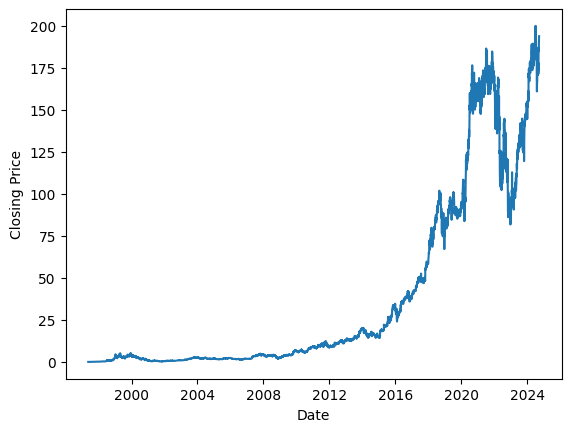

In [7]:
# see the trend in stockprice movement from one 1997 to 2024
data["Date"] = pd.to_datetime(data["Date"])

plt.plot(data["Date"], data["Close"])
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show();

#### Prepoare The Data For the LSTM

Since the model takes in historical data and predicts new data or values based on these data it is necessary to create a dataset that considers previous days as a squence of datasets that would hence be passed into the LSTM model.

In [8]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):

  df = dc(df)
  df["Date"] = pd.to_datetime(df["Date"])
  df.set_index("Date", inplace=True)

  for i in range(1, n_steps+1):
    df[f"Close(t-{i})"] = df["Close"].shift(i)

  df.dropna(inplace=True)
  return df

In [9]:
lookback_window = 7
shifted_data = prepare_dataframe_for_lstm(data, lookback_window)
shifted_data.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354


In [10]:
# convert the data into nparrays
shifted_data = np.array(shifted_data.values)
shifted_data


array([[7.91670009e-02, 7.50000030e-02, 6.97920024e-02, ...,
        8.54170024e-02, 8.64579976e-02, 9.79169980e-02],
       [7.65630007e-02, 7.91670009e-02, 7.50000030e-02, ...,
        8.17710012e-02, 8.54170024e-02, 8.64579976e-02],
       [7.52599984e-02, 7.65630007e-02, 7.91670009e-02, ...,
        7.13540018e-02, 8.17710012e-02, 8.54170024e-02],
       ...,
       [1.89869995e+02, 1.86429993e+02, 1.86880005e+02, ...,
        1.87000000e+02, 1.84520004e+02, 1.79550003e+02],
       [1.91600006e+02, 1.89869995e+02, 1.86429993e+02, ...,
        1.86490005e+02, 1.87000000e+02, 1.84520004e+02],
       [1.93880005e+02, 1.91600006e+02, 1.89869995e+02, ...,
        1.84889999e+02, 1.86490005e+02, 1.87000000e+02]])

In [11]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

shifted_data =sc.fit_transform(shifted_data)

In [12]:
X = shifted_data[:, 1:]
y = shifted_data[:,0]

The data is arranged from day 7 to day 1,however,in making predictions we seek to generate the data fromthe 7th date to the first date and then utilize it in predicting the new result. This is what we refer to as a sequence of dataset.

In [13]:
X = dc(np.flip(X, axis=1))

X

array([[1.40674067e-04, 8.33590646e-05, 7.81522720e-05, ...,
        7.81272293e-06, 0.00000000e+00, 2.08424088e-05],
       [8.33590646e-05, 7.81522720e-05, 5.99159022e-05, ...,
        0.00000000e+00, 2.60490928e-05, 4.16847802e-05],
       [7.81522720e-05, 5.99159022e-05, 7.81272293e-06, ...,
        2.60490928e-05, 4.68913558e-05, 2.86601660e-05],
       ...,
       [8.97714322e-01, 9.22573002e-01, 9.34977310e-01, ...,
        9.24423624e-01, 9.34377125e-01, 9.32125925e-01],
       [9.22573002e-01, 9.34977310e-01, 9.32426447e-01, ...,
        9.34377125e-01, 9.32126278e-01, 9.49332031e-01],
       [9.34977310e-01, 9.32426447e-01, 9.24423624e-01, ...,
        9.32126278e-01, 9.49332295e-01, 9.57985150e-01]])

when working with LSTMs we dont perfrom the usual random train test split thisis due to the fact that we are working with recurrent values and do not want to break the order with which they come (remember that recurrent data are those data that are arranged in order of timeand space). Thus, there must be another strategy with which we split the dataset.Here we will split the training data into the first 75% of the available data and then the next 25 percent can be used as the test data.

In [14]:
split_index = int(len(X) * 0.75)

split_index

5157

In [15]:
# split X and y into train and test set
X_train = X[: split_index]
y_train = y[: split_index]

X_test = X[split_index :]
y_test = y[split_index :]

print(f"X train: {X_train.shape} \n\n X test: {X_test.shape} \n\n y train: {y_train.shape} \n\n y test: {y_test.shape}")

X train: (5157, 7) 

 X test: (1720, 7) 

 y train: (5157,) 

 y test: (1720,)


In [16]:
# reshape the features and target values
X_train = X_train.reshape((-1, lookback_window, 1))
X_test = X_test.reshape((-1, lookback_window, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, y_train.shape

((5157, 7, 1), (5157, 1))

In [17]:
# convert all the values of the Xand y into torch tensors
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

print(f"X train: {X_train.shape} \n\n X test: {X_test.shape} \n\n y train: {y_train.shape} \n\n y test: {y_test.shape}")

X train: torch.Size([5157, 7, 1]) 

 X test: torch.Size([1720, 7, 1]) 

 y train: torch.Size([5157, 1]) 

 y test: torch.Size([1720, 1])


#### Creating The Class Generator

In [18]:
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]


In [19]:
# use the dataset class to load the alraedy transformed dataset
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [20]:
# wrap the dataset in dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=32, shuffle=True)

### create The LSTM model

In [33]:
class StockPredictor(nn.Module):

  def __init__(self, input_size, hidden_size, num_stacked_layer):
    super(StockPredictor, self).__init__()

    self.hidden_size = hidden_size
    self.num_stacked_layer =num_stacked_layer

    self.lstm = nn.LSTM(
        input_size,
        hidden_size,
        num_stacked_layer,
        batch_first = True
    )

    self.fc = nn.Linear(hidden_size,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_stacked_layer, x.size(0), self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layer, x.size(0), self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0,c0))
    out =self.fc(out[:, -1, :])

    return out


In [34]:
model = StockPredictor(1, 4, 1)
model.to(device)
model

StockPredictor(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

### The Training Loop

In [37]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(50):
  for seqs, labels in train_dataloader:
    #seqs = seqs.view(35, 7, 1)
    outputs = model(seqs)
    loss = loss_fn(outputs, labels)
    optimizer.zero_grad()
    optimizer.step()

#### Evaluation Loop

In [43]:
mean_square_err = torchmetrics.MeanSquaredError()

model.eval()
with torch.no_grad():
  for seqs, labels in test_dataloader:
    outputs = model(seqs)#.squeeze()
    mean_square_err(outputs, labels)

print(f"Test MSE: {mean_square_err.compute()}")

Test MSE: 0.055304620414972305
